# Visualizing the results of AP Feature Selector on 10 datasets

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from ast import literal_eval


In [3]:

df = pd.read_csv('ap_feature_selection_results.csv',sep=',')
df = df.drop('error', axis=1)
print(df.shape)
df.head()

(10, 7)


,dataset,task_type,base_score,selector_score,num_rows,n_features_original,n_features_selected
0,heart,Classification (Binary),"{'ap': 0.5740285483889488, 'roc_auc': 0.713333...","{'ap': 0.43607871157956046, 'roc_auc': 0.63333...",200,15,4
1,hepatitis,Classification (Binary),"{'ap': 0.4991455766455766, 'roc_auc': 0.504761...","{'ap': 0.5459782608695652, 'roc_auc': 0.602380...",154,19,7
2,blood,Classification (Binary),"{'ap': 0.45623638251455373, 'roc_auc': 0.58622...","{'ap': 0.45623638251455373, 'roc_auc': 0.58622...",748,4,4
3,cancer,Classification (Binary),"{'ap': 0.992078797674568, 'roc_auc': 0.9591881...","{'ap': 0.9949914349125089, 'roc_auc': 0.959188...",683,9,6
4,diabetes,Classification (Binary),"{'ap': 0.6154319151444712, 'roc_auc': 0.725252...","{'ap': 0.6468987449582155, 'roc_auc': 0.711111...",768,8,5


c:\ProgramData\Anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\ProgramData\Anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\Ram\AppData\Local\Temp\ipykernel_12896\2075895801.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats_df.index, y=stats_df['wilcoxon_p'],


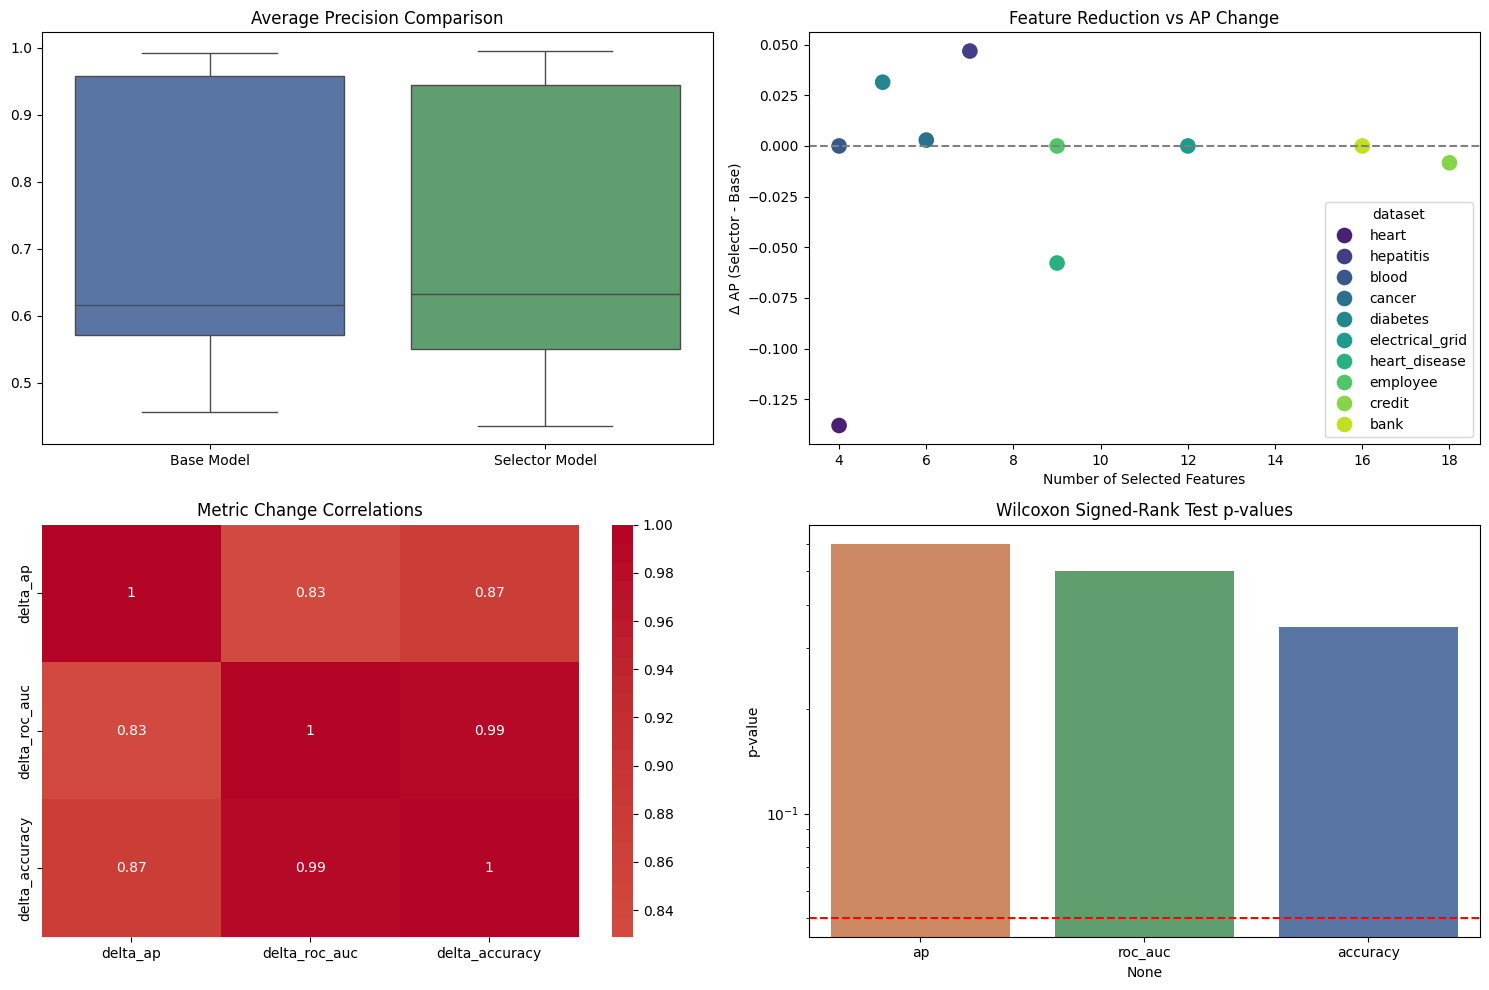

Statistical Analysis Results:
          wilcoxon_p  cohens_d
ap          0.600179 -0.055755
roc_auc     0.500184 -0.031667
accuracy    0.345231 -0.045677


In [4]:
# Convert string dictionaries to actual columns
for col in ['base_score', 'selector_score']:
    df[col] = df[col].apply(literal_eval)
    df = pd.concat([
        df.drop(col, axis=1),
        df[col].apply(pd.Series).add_prefix(f'{col}_')
    ], axis=1)

# Calculate differences
for metric in ['ap', 'roc_auc', 'accuracy']:
    df[f'delta_{metric}'] = df[f'selector_score_{metric}'] - df[f'base_score_{metric}']
    df[f'pct_change_{metric}'] = (df[f'delta_{metric}'] / df[f'base_score_{metric}']) * 100

# Statistical tests
results = {}
for metric in ['ap', 'roc_auc', 'accuracy']:
    stat, p = wilcoxon(df[f'base_score_{metric}'], df[f'selector_score_{metric}'])
    cohens_d = (df[f'selector_score_{metric}'].mean() - df[f'base_score_{metric}'].mean()) / np.sqrt((df[f'base_score_{metric}'].std()**2 + df[f'selector_score_{metric}'].std()**2)/2)
    results[metric] = {'wilcoxon_p': p, 'cohens_d': cohens_d}

stats_df = pd.DataFrame(results).T

# Visualization
plt.figure(figsize=(15, 10))

# 1. Performance Comparison
plt.subplot(2, 2, 1)
sns.boxplot(data=df[['base_score_ap', 'selector_score_ap']], 
            palette=["#4C72B0", "#55A868"])
plt.title('Average Precision Comparison')
plt.xticks([0, 1], ['Base Model', 'Selector Model'])

# 2. Feature Reduction vs Performance
plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='n_features_selected', y='delta_ap', 
                hue='dataset', s=150, palette='viridis')
plt.axhline(0, color='grey', linestyle='--')
plt.title('Feature Reduction vs AP Change')
plt.xlabel('Number of Selected Features')
plt.ylabel('Δ AP (Selector - Base)')

# 3. Metric Correlation
plt.subplot(2, 2, 3)
sns.heatmap(df[['delta_ap', 'delta_roc_auc', 'delta_accuracy']].corr(),
            annot=True, cmap='coolwarm', center=0)
plt.title('Metric Change Correlations')

# 4. Statistical Significance
plt.subplot(2, 2, 4)
sns.barplot(x=stats_df.index, y=stats_df['wilcoxon_p'], 
           palette=['#DD8452', '#55A868', '#4C72B0'])
plt.axhline(0.05, color='red', linestyle='--')
plt.title('Wilcoxon Signed-Rank Test p-values')
plt.ylabel('p-value')
plt.yscale('log')

plt.tight_layout()
plt.show()

# Print statistical results
print("Statistical Analysis Results:")
print(stats_df)

C:\Users\Ram\AppData\Local\Temp\ipykernel_12896\2666167230.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats_df.index, y=stats_df['cohens_d'], palette='viridis')


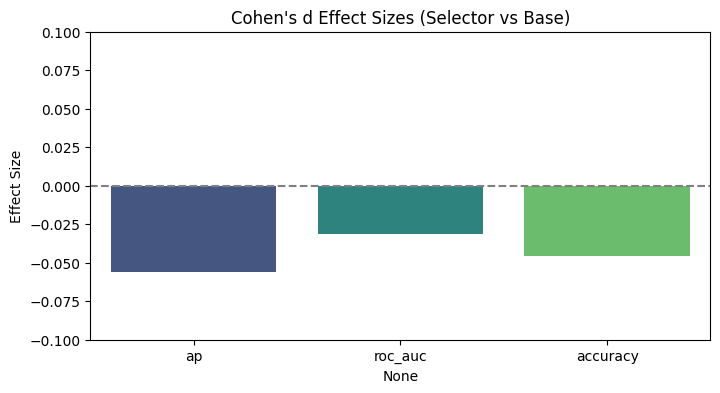

In [5]:
# Plot effect sizes
plt.figure(figsize=(8, 4))
sns.barplot(x=stats_df.index, y=stats_df['cohens_d'], palette='viridis')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Cohen's d Effect Sizes (Selector vs Base)")
plt.ylabel("Effect Size")
plt.ylim(-0.1, 0.1)
plt.show()


Cohen's D effect This confirms the trivial effect sizes observed in the analysis.